# Problem Statement
The objective of this exercise is to utilize both supervised and unsupervised machine learning methods to analyze and predict malware infections on Windows machines. The dataset comprises telemetry data collected from machines running Microsoft Windows OS, where each entry corresponds to a specific machine identified by a unique MachineIdentifier. 
The primary goal is to predict whether a machine will experience malware infection, indicated by the HasDetections target variable.

# Microsoft Malware Dataset Column Explanations:

1. Wdft_IsGamer: Indicates whether the device is a gamer device or not based on its hardware combination.
2. Census_IsVirtualDevice: Identifies a Virtual Machine (machine learning model).
3. Census_OSEdition: Edition of the current OS.
4. Census_HasOpticalDiskDrive: True indicates that the machine has an optical disk drive (CD/DVD).
5. Firewall: This attribute is true (1) for Windows 8.1 and above if Windows firewall is enabled, as reported by the service.
6. SMode: This field is set to true when the device is known to be in 'S Mode', as in Windows 10 S mode, where only Microsoft Store apps can be installed.
7. IsProtected: This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates.
8. OsPlatformSubRelease: Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2).
CountryIdentifier: ID for the country the machine is located in.


In [68]:
# Importing key libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [69]:
# Loading the dataset
df = pd.read_csv('Microsoft_malware_dataset_min.csv')

In [70]:
# data inspection
df.head()

,HasDetections,Wdft_IsGamer,Census_IsVirtualDevice,Census_OSEdition,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,OsPlatformSubRelease,CountryIdentifier
0,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,29
1,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,93
2,0,0.0,0.0,Core,0,1.0,0.0,1.0,rs4,86
3,1,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,88
4,1,0.0,0.0,Core,0,1.0,0.0,1.0,rs4,18


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HasDetections               100000 non-null  int64  
 1   Wdft_IsGamer                96585 non-null   float64
 2   Census_IsVirtualDevice      99815 non-null   float64
 3   Census_OSEdition            100000 non-null  object 
 4   Census_HasOpticalDiskDrive  100000 non-null  int64  
 5   Firewall                    98924 non-null   float64
 6   SMode                       94068 non-null   float64
 7   IsProtected                 99609 non-null   float64
 8   OsPlatformSubRelease        100000 non-null  object 
 9   CountryIdentifier           100000 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 7.6+ MB


In [72]:
df.describe()

,HasDetections,Wdft_IsGamer,Census_IsVirtualDevice,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,CountryIdentifier
count,100000.000000,96585.000000,99815.000000,100000.000000,98924.000000,94068.000000,99609.000000,100000.000000
mean,0.499280,0.281607,0.006642,0.075850,0.977326,0.000351,0.944864,108.188050
std,0.500002,0.449785,0.081230,0.264759,0.148863,0.018727,0.228246,62.989406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,51.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,97.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,162.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,222.000000


EDA

In [73]:
# pandas profiling report
profile = ProfileReport(df, title="YData Profiling Report", explorative=True)

In [74]:
# Display the report in Jupyter Notebook 
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
# checking for and handling missing values
df.isnull().sum()

HasDetections                    0
Wdft_IsGamer                  3415
Census_IsVirtualDevice         185
Census_OSEdition                 0
Census_HasOpticalDiskDrive       0
Firewall                      1076
SMode                         5932
IsProtected                    391
OsPlatformSubRelease             0
CountryIdentifier                0
dtype: int64

In [76]:
# transforming columns
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

In [77]:
df.columns

Index(['hasdetections', 'wdft_isgamer', 'census_isvirtualdevice',
       'census_osedition', 'census_hasopticaldiskdrive', 'firewall', 'smode',
       'isprotected', 'osplatformsubrelease', 'countryidentifier'],
      dtype='object')

In [78]:
# handling missing values by mode imputation

feature_list = ['hasdetections', 'wdft_isgamer', 'census_isvirtualdevice',
       'census_osedition', 'census_hasopticaldiskdrive', 'firewall', 'smode',
       'isprotected', 'osplatformsubrelease', 'countryidentifier']

# Fill missing values with the mode for each feature in the list above.
for feature in feature_list:
    mode_value = df[feature].mode()[0]  # Getting the mode value for each feature
    df[feature].fillna(mode_value, inplace=True)

# confirm whether missing values are filled
df[feature_list].isnull().sum()

/var/folders/js/8bnyws5d18x0g67dk4jcfp8w0000gn/T/ipykernel_2885/2360335350.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(mode_value, inplace=True)
/var/folders/js/8bnyws5d18x0g67dk4jcfp8w0000gn/T/ipykernel_2885/2360335350.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

hasdetections                 0
wdft_isgamer                  0
census_isvirtualdevice        0
census_osedition              0
census_hasopticaldiskdrive    0
firewall                      0
smode                         0
isprotected                   0
osplatformsubrelease          0
countryidentifier             0
dtype: int64

In [79]:
# removing duplicates that the profile report indicated as available
df.drop_duplicates(inplace=True)

In [80]:
# OUTLIER DETECTION AND HANDLING

# function to detect outliers based on IQR

def detect_outliers_iqr(df):
    outliers = pd.DataFrame()
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # rows where the value is outside the IQR bounds
        outliers_in_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers = pd.concat([outliers, outliers_in_col])
    
    return outliers

# Applying the IQR method to detect outliers
outliers_iqr = detect_outliers_iqr(df)
print(f'Number of outliers found: {outliers_iqr.shape[0]}')
outliers_iqr.head()


Number of outliers found: 8495


,hasdetections,wdft_isgamer,census_isvirtualdevice,census_osedition,census_hasopticaldiskdrive,firewall,smode,isprotected,osplatformsubrelease,countryidentifier
111,0,0.0,1.0,Professional,0,1.0,0.0,1.0,rs3,44
123,0,0.0,1.0,Professional,0,1.0,0.0,0.0,rs3,103
134,0,0.0,1.0,Professional,0,1.0,0.0,1.0,rs4,155
324,0,0.0,1.0,Professional,0,1.0,0.0,1.0,rs4,21
328,0,0.0,1.0,Core,0,1.0,0.0,1.0,rs4,203


In [81]:
# handling the outliers through capping

# Function to cap outliers in numerical cols
def cap_outliers(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in numerical_cols:
        
        lower_cap = df[col].quantile(0.01)
        upper_cap = df[col].quantile(0.99)
        

        df[col] = np.where(df[col] < lower_cap, lower_cap, 
                           np.where(df[col] > upper_cap, upper_cap, df[col]))
    
    return df

# Applying the capping function
df_capped = cap_outliers(df)

In [82]:
# Confirming if outliers have been capped
df_capped.describe()

,hasdetections,wdft_isgamer,census_isvirtualdevice,census_hasopticaldiskdrive,firewall,smode,isprotected,countryidentifier
count,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.0,16114.000000,16114.000000
mean,0.469468,0.344793,0.029974,0.215837,0.909023,0.0,0.811592,110.532767
std,0.499082,0.475316,0.170521,0.411415,0.287585,0.0,0.391049,62.800108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,56.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,104.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,164.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,220.000000


In [83]:
# Encoding categorical features

for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [84]:
# Preparing the data for modeling

X = df.drop('hasdetections', axis=1)
y = df['hasdetections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Decision Tree modeling

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)[:,1]

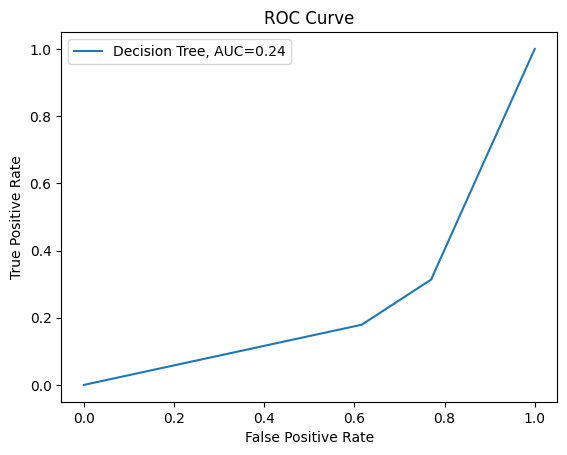

In [89]:
# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"Decision Tree, AUC={roc_auc_score(y_test, y_pred):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [87]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_

In [88]:
# Evaluate the best model
best_y_pred = best_dt.predict_proba(X_test)[:,1]
print(f"Best ROC AUC: {roc_auc_score(y_test, best_y_pred):.2f}")

Best ROC AUC: 0.54


# part 2: Unsupervised learning

In [90]:
# importing key libs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [91]:
# Removing the target column and standardizing features for clustering
X_unsupervised = X.copy()  # X without the target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

In [92]:
# PCA for visualizing clusters in 2D
# PCA reduces data dimensionality for easier visualization of clusters.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [93]:
# Applying K-Means clustering with an initial choice of k as 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

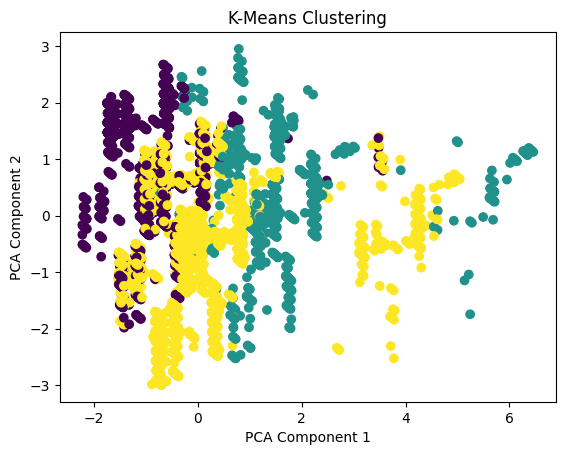

In [94]:
# Visualize the clusters in PCA-reduced 2D space
# for verifying if distinct clusters form, making results more interpretable.

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

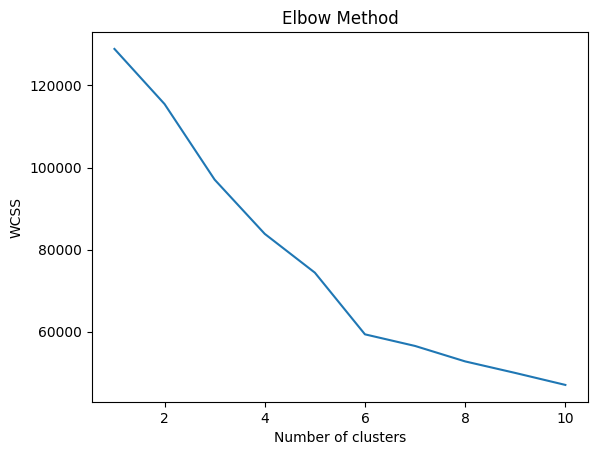

In [95]:
# Using the Elbow method to find the optimal number of clusters, K
# The Elbow method shows where additional clusters don’t significantly improve WCSS, suggesting the best K.

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [107]:
# Calculating the silhouette score to validate the quality of the optimal clusters(measures how well-separated the clusters are, confirming whether the chosen K is effective.)
optimal_k = 6
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for {optimal_k} clusters: {silhouette_avg:.2f}")
# The silhouette score 

Silhouette Score for 6 clusters: 0.26


The optimal k value is 6 since it has the best silhoutte score, meaning the elbow method specified it accurately